In [19]:
# Swiss Roll Dataset Clustering Test
# Setup: Import libraries and configure environment

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Setup Python path to import from project root
sys.path.append(os.path.abspath('..'))

# Import core libraries
from sklearn.datasets import make_swiss_roll
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

# Import KL clustering modules
from kl_clustering_analysis.tree.poset_tree import PosetTree
from kl_clustering_analysis import config
from kl_clustering_analysis.plot.cluster_tree_visualization import plot_tree_with_clusters
from kl_clustering_analysis.plot.cluster_color_mapping import build_cluster_color_spec

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [10]:
# Define Swiss Roll Dataset Generator

def create_swiss_roll_dataset(n_samples=300, noise=0.1, seed=42):
    """
    Create a Swiss roll dataset and binarize it for clustering.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    noise : float
        Standard deviation of gaussian noise
    seed : int
        Random seed for reproducibility
        
    Returns
    -------
    data : pd.DataFrame
        Binarized feature matrix
    y_true : np.ndarray
        True position labels on the roll
    X : np.ndarray
        Original 3D coordinates
    """
    # Generate Swiss roll
    X, y_true = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=seed)

    # Binarize features (above/below median for each dimension)
    X_binary = (X > np.median(X, axis=0)).astype(int)
    data = pd.DataFrame(
        X_binary,
        index=[f"R{j}" for j in range(len(X))],
        columns=[f"F{j}" for j in range(X.shape[1])],
    )

    return data, y_true, X

print("✓ Dataset generator function defined")


✓ Dataset generator function defined


In [11]:
# Generate Swiss Roll Data

print("Generating Swiss roll dataset...")
swiss_data, swiss_labels, swiss_coords = create_swiss_roll_dataset(
    n_samples=300, 
    noise=0.1
)

print(f"✓ Dataset generated:")
print(f"  - Samples: {len(swiss_data)}")
print(f"  - Features: {swiss_data.shape[1]}")
print(f"  - Data shape: {swiss_data.shape}")


Generating Swiss roll dataset...
✓ Dataset generated:
  - Samples: 300
  - Features: 3
  - Data shape: (300, 3)


In [26]:
# Build Hierarchical Tree and Run Clustering

print("Building hierarchical tree...")
Z_swiss = linkage(pdist(swiss_data.values, metric="hamming"), method="complete")
tree_swiss = PosetTree.from_linkage(Z_swiss, leaf_names=swiss_data.index.tolist())

print("Running KL-based cluster decomposition...")
result_swiss = tree_swiss.decompose(
    leaf_data=swiss_data,
    alpha_local=config.ALPHA_LOCAL,
)

# Extract the results_df that was computed internally
results_df_swiss = tree_swiss.stats_df

print(f"✓ Clustering complete:")
print(f"  - Clusters found: {result_swiss['num_clusters']}")


Building hierarchical tree...
Running KL-based cluster decomposition...
✓ Clustering complete:
  - Clusters found: 8


In [27]:
# Create Report DataFrame

# Create report dataframe from cluster assignments
cluster_assignments = result_swiss.get("cluster_assignments", {})
if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_size": info["size"],
            })
    report_swiss = pd.DataFrame(rows).set_index("sample_id")
else:
    report_swiss = pd.DataFrame(columns=["cluster_id", "cluster_size"])

print(f"✓ Report created:")
print(f"  - Total samples: {len(report_swiss)}")
if not report_swiss.empty:
    print(f"  - Cluster distribution:")
    print(report_swiss['cluster_id'].value_counts().sort_index())


✓ Report created:
  - Total samples: 300
  - Cluster distribution:
cluster_id
0    44
1    33
2    41
3    32
4    41
5    32
6    44
7    33
Name: count, dtype: int64


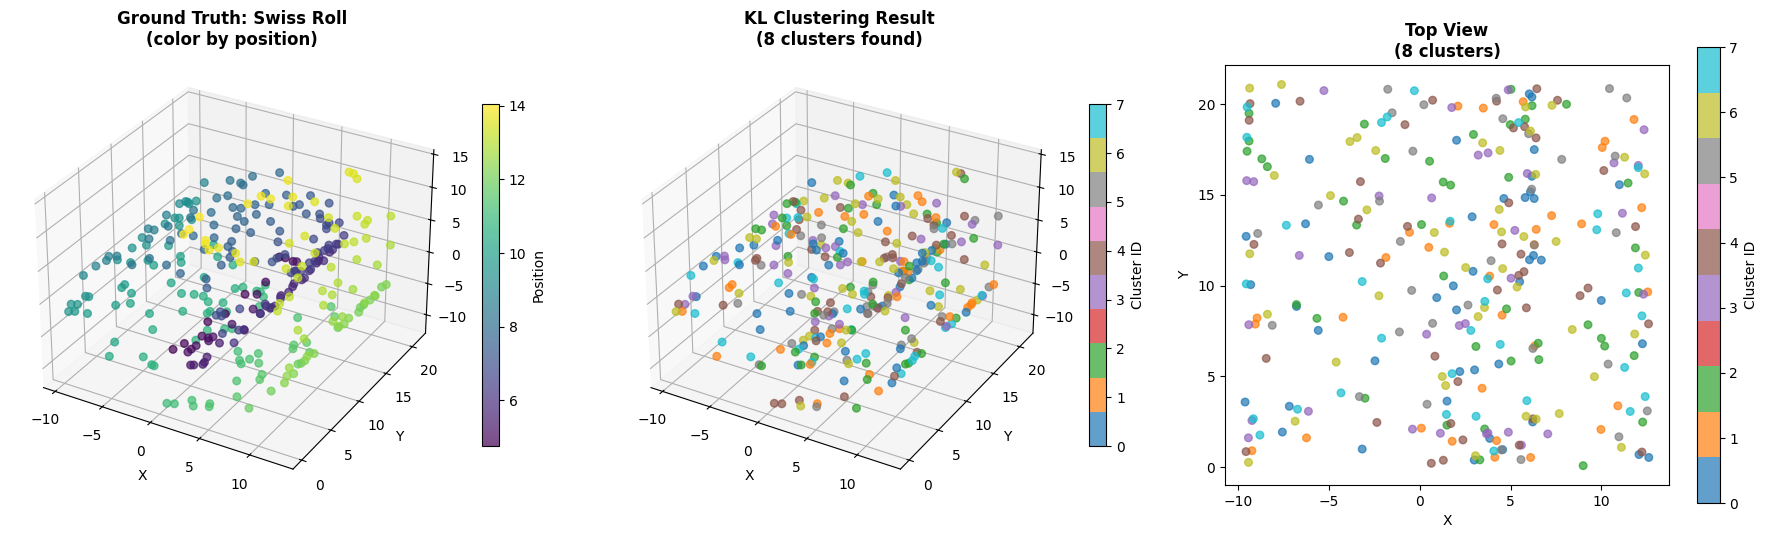

✓ Visualization complete


In [28]:
# Visualize Results in 3D

fig = plt.figure(figsize=(18, 6))

# Plot 1: Ground truth (color by position on roll)
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(
    swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
    c=swiss_labels, cmap='viridis', alpha=0.7, s=30
)
ax1.set_title('Ground Truth: Swiss Roll\n(color by position)', fontsize=12, fontweight='bold')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
plt.colorbar(scatter1, ax=ax1, label='Position', shrink=0.6)

# Plot 2: Clustering result (3D view)
ax2 = fig.add_subplot(132, projection='3d')
if not report_swiss.empty:
    cluster_ids = report_swiss['cluster_id'].values
    scatter2 = ax2.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
        c=cluster_ids, cmap='tab10', alpha=0.7, s=30
    )
else:
    scatter2 = ax2.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2],
        c='gray', alpha=0.7, s=30
    )

ax2.set_title(f'KL Clustering Result\n({result_swiss["num_clusters"]} clusters found)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.colorbar(scatter2, ax=ax2, label='Cluster ID', shrink=0.6)

# Plot 3: Top-down view of clustering
ax3 = fig.add_subplot(133)
if not report_swiss.empty:
    scatter3 = ax3.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1],
        c=cluster_ids, cmap='tab10', alpha=0.7, s=30
    )
else:
    scatter3 = ax3.scatter(
        swiss_coords[:, 0], swiss_coords[:, 1],
        c='gray', alpha=0.7, s=30
    )

ax3.set_title(f'Top View\n({result_swiss["num_clusters"]} clusters)', 
              fontsize=12, fontweight='bold')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_aspect('equal')
plt.colorbar(scatter3, ax=ax3, label='Cluster ID', shrink=0.8)

plt.tight_layout()
plt.savefig('../cluster_tree_plots/swiss_roll_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization complete")



DEBUG: Cluster Color Mapping
Number of clusters: 8
Generating tree visualization...


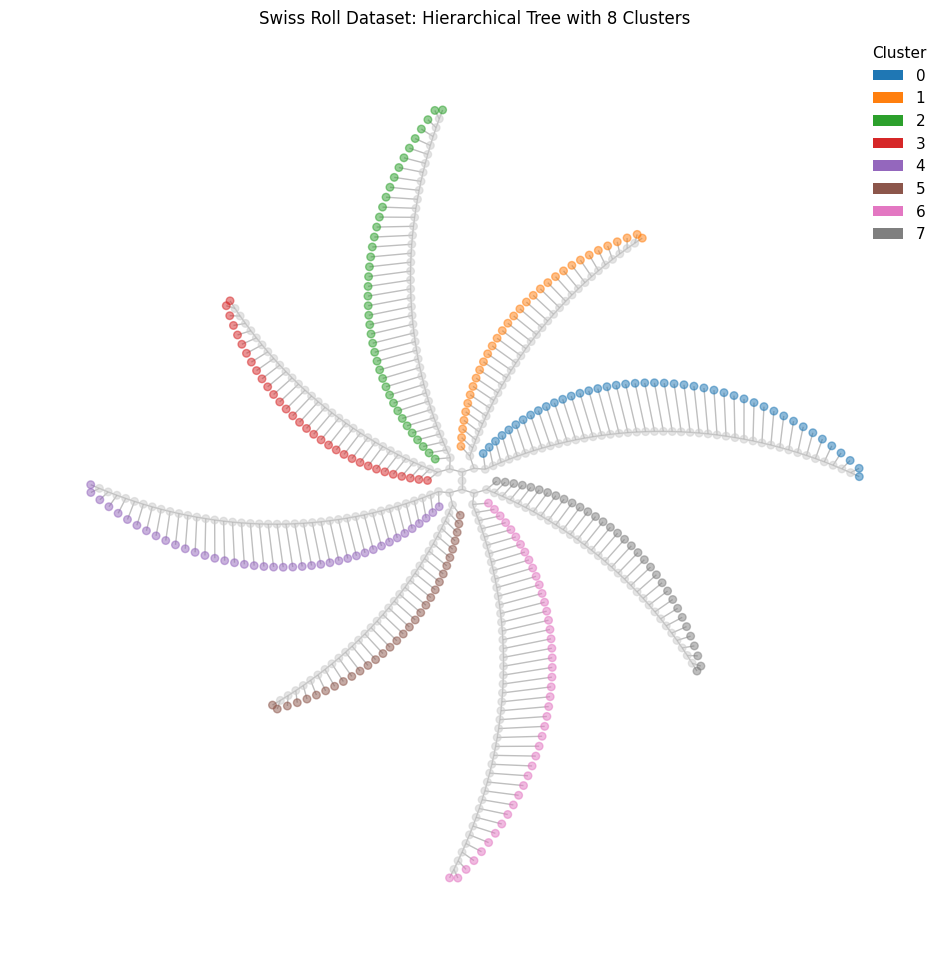

✓ Tree visualization complete


<Figure size 640x480 with 0 Axes>

In [29]:
# Visualize Cluster Tree Structure

# Debug: Check color mapping
from kl_clustering_analysis.plot.cluster_color_mapping import build_cluster_color_spec

print("\n" + "="*60)
print("DEBUG: Cluster Color Mapping")
print("="*60)
print(f"Number of clusters: {result_swiss['num_clusters']}")

spec = build_cluster_color_spec(
    result_swiss['num_clusters'], 
    base_cmap='viridis', 
    unassigned_color="#CCCCCC"
)


print("Generating tree visualization...")
fig_tree, ax_tree = plot_tree_with_clusters(
    tree=tree_swiss,
    decomposition_results=result_swiss,
    results_df=results_df_swiss,
    figsize=(12, 12),
    node_size=30,
    font_size=12,
    title=f"Swiss Roll Dataset: Hierarchical Tree with {result_swiss['num_clusters']} Clusters",
    colormap='tab10',  # Changed from 'viridis' to 'tab10' for better distinction
    show=True
)

# Save tree visualization
plt.savefig('../cluster_tree_plots/swiss_roll_tree_structure.png', dpi=150, bbox_inches='tight')
print("✓ Tree visualization complete")

In [15]:
# Save Results to CSV

current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/swiss_roll_clustering_results_{current_date}.csv"

# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Save the report
report_swiss.to_csv(results_file)

print(f"✓ Results saved:")
print(f"  - File: {results_file}")
print(f"  - Visualization: ../cluster_tree_plots/swiss_roll_clustering_test.png")
print(f"\n{'='*60}")
print(f"Test completed successfully!")
print(f"{'='*60}")


✓ Results saved:
  - File: ../results/swiss_roll_clustering_results_2025-12-17_13-20-35.csv
  - Visualization: ../cluster_tree_plots/swiss_roll_clustering_test.png

Test completed successfully!
